In [1]:
import pandas as pd
import numpy as np
import os
import json
import cv2
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as utils
import torchvision.transforms.functional as tf
import torch.nn.functional as f
import torchvision
import torchmetrics as metrics
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import LearningRateMonitor
from PIL import Image, ImageColor
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset, random_split
from pathlib import Path
from torchmetrics.functional.classification import multilabel_precision, multilabel_recall
import random
from sklearn.model_selection import train_test_split
from architecture import SimpleAttentionCNN
from torchmetrics.classification import MulticlassAccuracy
from sklearn.preprocessing import LabelEncoder

In [2]:

df = pd.read_csv('dataset/age_detection.csv')
df

,file,age,split
0,train/18-20/0.jpg,18-20,train
1,train/18-20/1.jpg,18-20,train
2,train/18-20/2.jpg,18-20,train
3,train/18-20/3.jpg,18-20,train
4,train/18-20/4.jpg,18-20,train
...,...,...,...
145,test/51-60/25.jpg,51-60,test
146,test/51-60/26.jpg,51-60,test
147,test/51-60/27.jpg,51-60,test
148,test/51-60/28.jpg,51-60,test


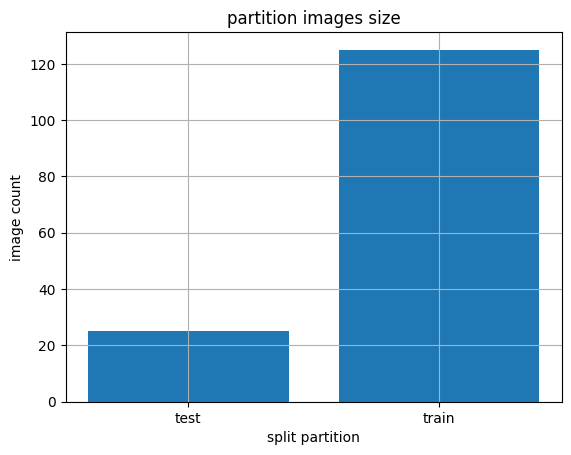

In [3]:
grouped = df.groupby('split').size().reset_index(name='count')
plt.bar(grouped['split'], grouped['count'])
plt.xlabel('split partition')
plt.ylabel('image count')
plt.title('partition images size')
plt.grid(True)

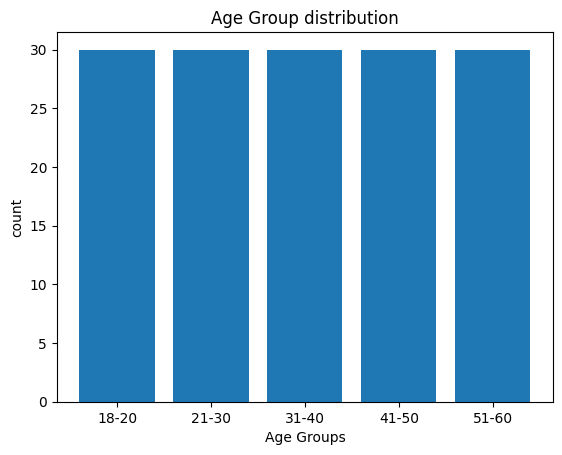

In [4]:
ageGrouped = df.groupby('age').size().reset_index(name='age-count')
plt.bar(ageGrouped['age'], ageGrouped['age-count'])
plt.xlabel('Age Groups')
plt.ylabel('count')
plt.title('Age Group distribution')
plt.show()

In [5]:
nClass = df['age'].unique()
datadir = 'dataset'

In [6]:
dfEncoded = df.copy(True)
encoder = LabelEncoder()
encoder.fit(dfEncoded['age'])
dfEncoded['age'] = encoder.transform(dfEncoded['age'])
dfEncoded

,file,age,split
0,train/18-20/0.jpg,0,train
1,train/18-20/1.jpg,0,train
2,train/18-20/2.jpg,0,train
3,train/18-20/3.jpg,0,train
4,train/18-20/4.jpg,0,train
...,...,...,...
145,test/51-60/25.jpg,4,test
146,test/51-60/26.jpg,4,test
147,test/51-60/27.jpg,4,test
148,test/51-60/28.jpg,4,test


In [8]:
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS


class customDataset(Dataset):
    def __init__(self, df, datadir=None, transforms=None):
        if df is None:
            raise ValueError('df and partition parameter should be specified')
        if datadir is None:
            raise ValueError('data directory must be specified')
        
        # self.df = df
        self.transforms = transforms
        self.datadir = datadir
        self.imageList = df['file'].tolist()
        self.targetList = df['age'].tolist()
    def __len__(self):
        return len(df)
    def __getitem__(self, index):
        image = np.array(Image.open(os.path.join(self.datadir, self.imageList[index])), dtype=np.float32)
        label = self.targetList[index]
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        # image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

class dataModule(pl.LightningDataModule):
    def __init__(self, df, datadir=None, batchSize=16, trainSplit=.8, validationSplit=.2):
        super().__init__()
        if df is None:
            raise ValueError('df cannot be empty')
        if datadir is None:
            raise ValueError('datadir cannot be empty')
        if isinstance(trainSplit, float) != True and isinstance(validationSplit, float) != True:
            raise TypeError(f'trainSplit and validationSplit should be float, found {type(trainSplit)} and {type(validationSplit)}')
        if trainSplit+validationSplit != 1:
            raise ValueError('The sum of training and validation split must be 1')
        
        self.df = df
        self.datadir = datadir
        self.batchSize = batchSize
        self.trainSplit = trainSplit
        self.validationSplit = validationSplit

    def prepare_data(self):
        pass

    def _getTransform(self, phase='train'):
        if phase == 'train':
            return A.Compose([
                A.Resize(256,256),
                A.OneOf([
                    A.RandomBrightness(),
                    A.RandomRotate90(),
                    A.HorizontalFlip(),
                    A.VerticalFlip(),
                ]),
                ToTensorV2()
            ])
        elif phase == 'validation' or phase == 'test':
            return A.Compose([
                A.Resize(256, 256),
                ToTensorV2()
            ])
    def setup(self, stage:str):
        trainTransform = self._getTransform()
        validationTransform = self._getTransform(phase='validation')
        trainDf = self.df[self.df['split']=='train']
        testDf = self.df[self.df['split']=='test']
        train, val = train_test_split(trainDf, train_size=self.trainSplit)
        self.trainSet = customDataset(train, self.datadir, trainTransform)
        self.validationSet = customDataset(val, self.datadir, validationTransform)
        self.testSet = customDataset(testDf, self.datadir, validationTransform)
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        # return DataLoader(self.trainSet, batch_size=self.batchSize, pin_memory=True, num_workers=8, drop_last=True)
        return DataLoader(self.trainSet, batch_size=self.batchSize, drop_last=True)
    def val_dataloader(self) -> EVAL_DATALOADERS:
        # return DataLoader(self.validationSet, batch_size=self.batchSize, pin_memory=True, num_workers=8, drop_last=True)
        return DataLoader(self.validationSet, batch_size=self.batchSize, drop_last=True)
    def predict_dataloader(self) -> EVAL_DATALOADERS:
        # return DataLoader(self.testSet, batch_sampler=self.batchSize, pin_memory=True, num_workers=8, drop_last=True)
        return DataLoader(self.testSet, batch_sampler=self.batchSize, drop_last=True)

In [7]:
model = SimpleAttentionCNN(in_channel=3, in_size=256, num_classes=len(nClass), spatial_attention=True, channel_attention=True)
summary(model, input_size=(1,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleAttentionCNN                       [1, 3, 256, 256]          --
├─Sequential: 1-1                        [1, 256, 256, 256]        --
│    └─Conv2d: 2-1                       [1, 64, 256, 256]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 256, 256]         128
│    └─ReLU: 2-3                         [1, 64, 256, 256]         --
│    └─Conv2d: 2-4                       [1, 128, 256, 256]        73,856
│    └─BatchNorm2d: 2-5                  [1, 128, 256, 256]        256
│    └─ReLU: 2-6                         [1, 128, 256, 256]        --
│    └─Conv2d: 2-7                       [1, 256, 256, 256]        295,168
├─SpatialAttention: 1-2                  [1, 256, 256, 256]        --
│    └─Conv2d: 2-8                       [1, 1, 256, 256]          18
│    └─Sigmoid: 2-9                      [1, 1, 256, 256]          --
├─ChannelAttention: 1-3                  [1, 256, 256, 256]        --
│

In [9]:
class classifierModule(pl.LightningModule):
    def __init__(self, nClasses=len(nClass), lr=0.01, decay=0):
        super().__init__()
        self.model = SimpleAttentionCNN(in_channel=3, in_size=256, num_classes=nClasses)
        self.nClasses = nClasses
        self.lr = lr
        self.decay = decay
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = MulticlassAccuracy(num_classes=nClasses)
    def forward(self, x):
        logits = self.model(x)
        return logits
    def training_step(self, batch, batchIdx):
        img, label = batch
        prediction = self.forward(img)
        loss = self.criterion(prediction, label)
        accuracy = self.accuracy(prediction, label)
        self.log_dict({'trainAcc' : accuracy, 'trainLoss' : loss}, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    def validation_step(self, batch, batchIdx):
        img, label = batch
        prediction = self.forward(img)
        loss = self.criterion(prediction, label)
        accuracy = self.accuracy(prediction, label)
        self.log_dict({'valAcc' : accuracy, 'valLoss' : loss}, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    def predict_step(self, batch, batch_idx):
        img, label = batch
        logits = self.forward(img)
        prediction = torch.argmax(logits, dim=1)
        return img, label, prediction.squeeze().cpu().numpy()
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.decay)
        return optimizer


In [10]:
dataMod = dataModule(df=dfEncoded, datadir=datadir, batchSize=16)
model = classifierModule(lr = .01, decay=0)
lrMonitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(max_epochs=1, callbacks=[lrMonitor])
trainer.fit(model=model, datamodule=dataMod)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | SimpleAttentionCNN | 513 K 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
513 K     Trainable params
0         Non-trainable params
513 K     Total params
2.054     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


torch.Size([16, 3, 256, 256])
torch.Size([16])


KeyboardInterrupt: 